# 単眼深度推定モデルを学習する
このノートではいよいよ単眼深度推定モデルの学習を行う。
ここでは簡単のために、最もシンプルなLossとネットワークをもちいて大枠の学習の方法を見ていく。

## ハイパーパラメタ
まずはじめにハイパーパラメタを設定しておく

In [1]:
frame_inds = [0, -1]  # 隣接フレームの番号
epochs = 100
lr = 0.0004
batch_size = 32

## ネットワーク
学習するネットワークは現在のフレームの深度マップを推定するものと、フレーム間の姿勢の変化を推定するものの２つである。<br>
ここではそれぞれdepth netとpose netと呼ぶ。
* depth netは深度マップを推定するネットワーク
* pose netは回転（X軸,Y軸,Z軸）と並進（X,Y,Z）の合計6個の数値を推定するネットワーク

### depth net
ここではネットワークの詳細に関心はないため、`segmentation_models_pytorch` をつかいU-Netを定義する。<br>
最新の深度推定モデルは複数の解像度の深度マップを推定するのが一般的だが、ここではGPUのメモリを節約するために１枚のみとする。

In [2]:
import segmentation_models_pytorch as smp
import torch

depth_net = smp.Unet('efficientnet-b0', in_channels=3, classes=1, activation=None)

# 入出力確認
depth_net(torch.zeros(1, 3, 224, 224))

tensor([[[[ -1.0524,  -0.6532,   0.5246,  ...,  -3.6662,  -3.9084,  -4.5565],
          [ -1.7578,  -0.9310,   2.6745,  ...,  -7.8614,  -5.6324,  -8.4204],
          [ -1.7847,  -3.4974,  -0.3256,  ..., -10.8736,  -5.2495,  -8.7360],
          ...,
          [ -3.0392,  -1.9095,  -3.1668,  ...,  -2.6860,  -4.6810,  -4.2104],
          [ -3.7319,  -4.4348,  -5.3645,  ...,  -2.3516,  -3.6499,  -6.2461],
          [ -2.5295,  -9.9995, -10.4278,  ...,  -5.9116,  -4.0271,  -2.0654]]]],
       grad_fn=<MkldnnConvolutionBackward0>)

### pose net

pose netに関してもネットワークの詳細には関心がないため、torchvisionの学習済みモデルを持ってきて、部分的にレイヤーを差し替える。<br>
現在フレームと隣接フレームの２枚を入力し、その２枚の間で発生した姿勢の変化量を推定する。
* 入力：２枚の画像はチャンネルの次元で結合して合計で6チャンネルのテンソルとして入力を行う。
* 出力：出力は並進（X軸, Y軸, Z軸）と回転（X軸, Y軸, Z軸）の6DoFである。

In [3]:
from torchvision.models import resnet18
from torch.nn import Linear, Conv2d

pose_net = resnet18(pretrained=True)
pose_net.conv1 = Conv2d(in_channels=3*2, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False)
pose_net.fc = Linear(in_features=512, out_features=6)

# 初期はすべて0を出力したほうが都合がよいので、weightとbiasを0クリアしておく
# reproj_loss_ += torch.randn(reproj_loss_.shape).to(device=reproj_loss_.device) * 1e-3
pose_net.fc.weight.data = torch.randn(pose_net.fc.weight.shape) * 1e-5
pose_net.fc.bias.data = torch.randn(pose_net.fc.bias.shape) * 1e-5

# 入出力確認
pose_net(torch.zeros(1, 3*2, 224, 224))

tensor([[-1.6915e-05,  6.0115e-06,  2.3402e-04, -9.6894e-05,  1.3139e-04,
         -3.3715e-05]], grad_fn=<AddmmBackward0>)

## Loss関数
ここではPhotometric lossとSmoothness lossを定義する。<br>
Photometric lossは推定した深度と姿勢変化からSourceの画像をTargetの画像に重ね合わせて一致しているかどうかを[l1](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html)と[SSIM](https://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.2.5689)で測る。<br>
また、Monodepth2で提案されたOcculusionや動体から生じる原理的に復元不可能な画素に対するLossの計算を回避するauto-maskingを導入した。

Smoothness lossはPhotometric lossの復元誤差が濃淡が平滑な領域で勾配を得にくいという問題を解消するために導入した。<br>
このlossは近接ピクセルがおおよそ同じような深度を持っている（物体の境界以外は）という仮定のもと、それをLossとして与えるものである。<br>
実装は様々あるが、ここではX,Y方向の差分のみから計算する比較的にシンプルなものを用いる。

In [4]:
import sys
sys.path.append("../../src")

In [5]:
import torch.nn.functional as F
from camera import PinholeCamera
from functools import lru_cache
import torchgeometry as tgm


class PhotometricLoss(torch.nn.Module):

    def __init__(self, frame_inds, weights=[0.6, 0.4], automasking=False):
        """
        Photometric loss
        weights: l1とssimのlossに対する重みを指定する。デフォルトは[0.4, 0.6]
        """
        super().__init__()
        self.frame_inds = frame_inds
        self.l1_loss = torch.nn.L1Loss(reduction="none")
        self.ssim_loss = tgm.losses.SSIM(reduction='none', window_size=3)
        self.weights = weights
        self.automasking = automasking

    def forward(self, y, y_pred):
        image_target = y["rgb_0"]
        depth = y_pred[f"depth_0"]
        intrinsic = y["intrinsic_0"]

        reproj_loss = []
        image_warped = {}
        for idx in self.frame_inds:
            if idx == 0: # ターゲット同士は比較しない
                continue
            image_source = y[f"rgb_{idx}"]
            extrinsic_src2tgt = y_pred[f"extrinsic_{idx}"]
            image_warped_ = self.warp(image_source, depth, intrinsic, extrinsic_src2tgt)
            l1_loss = self.l1_loss(image_warped_, image_target)
            ssim_loss = self.ssim_loss(image_warped_, image_target)
            reproj_loss_ = l1_loss * self.weights[0] + ssim_loss * self.weights[1]
            reproj_loss_ = torch.mean(reproj_loss_, dim=1) # auto-maskingで扱いやすいようにチャンネルの次元を潰しておく
            reproj_loss.append(reproj_loss_)
            image_warped[idx] = image_warped_
        
        if self.automasking:
            # auto-masking (https://arxiv.org/pdf/1806.01260.pdf) 何も変更を加えないSource画像を利用する。
            for idx in self.frame_inds:
                if idx == 0: # ターゲット同士は比較しない
                    continue
                image_source = y[f"rgb_{idx}"]
                l1_loss = self.l1_loss(image_source, image_target)
                ssim_loss = self.ssim_loss(image_source, image_target)
                reproj_loss_ = l1_loss * self.weights[0] + ssim_loss * self.weights[1]
                # 平坦な領域ではWarpされたものと何も変更を加えないものでLossが全くおなじになってしまう画素が生じる可能性があるので微小な乱数を加える
                reproj_loss_ += torch.randn(reproj_loss_.shape).to(device=reproj_loss_.device) * 1e-3
                reproj_loss_ = torch.mean(reproj_loss_, dim=1) # auto-maskingで扱いやすいようにチャンネルの次元を潰しておく
                reproj_loss.append(reproj_loss_)

            reproj_loss = torch.stack(reproj_loss, dim=1)
            loss, min_inds = torch.min(reproj_loss, dim=1)
            automask = (min_inds >= (reproj_loss.shape[1] // 2)).float()
            loss = reproj_loss.mean()
        else:
            loss = torch.stack(reproj_loss, dim=1)
            automask = torch.zeros_like(loss).squeeze(1) # dummy
            loss = loss.mean()
        
        return loss, image_warped, automask

    def warp(self, image_source, depth, intrinsic, extrinsic_src2tgt):        
        """ 推定された深度と姿勢からソースをターゲットに重ね合わせる """
        image_coords = self.create_image_coords(depth.shape)
        image_coords = image_coords.to(depth.device)
        world_coords = PinholeCamera.image2world(image_coords, intrinsic, extrinsic_src2tgt, depth, batch=True)        
        # これまでノートとは異なりターゲットのカメラへの座標変換が終わっているのでworld2camera()ではなくcamera2image()を呼び出す
        image_coords = PinholeCamera.camera2image(world_coords[..., :3], intrinsic, batch=True)
        # PyTorchのgrid samplingはcv2.remapとは異なり、座標が[-1, 1]に正規化されたものを入力する
        image_coords[..., 0] = image_coords[..., 0] / image_coords.shape[2] * 2 - 1
        image_coords[..., 1] = image_coords[..., 1] / image_coords.shape[1] * 2 - 1
        grid = image_coords
        image_warped = F.grid_sample(image_source, grid, align_corners=False)
        return image_warped
                
    @lru_cache(None)
    def create_image_coords(self, map_shape):
        """ 各画素に対する画像座標を生成する """
        xi = torch.arange(0, map_shape[2], 1)
        yi = torch.arange(0, map_shape[1], 1)
        coord_x, coord_y = torch.meshgrid(xi, yi, indexing="xy")
        image_coords = torch.stack([coord_x, coord_y], axis=-1)
        image_coords = image_coords.float()        
        image_coords = image_coords.unsqueeze(0).repeat(map_shape[0], 1, 1, 1) # バッチ化
        return image_coords


class SmoothnessLoss(torch.nn.Module):

    def forward(self, y, y_pred):
        depth = y_pred[f"inv_depth_0"]
        gradients_y = torch.mean(torch.abs(inv_depth[..., :-1,  :] - inv_depth[..., 1:,  :]))
        gradients_x = torch.mean(torch.abs(inv_depth[..., :  ,:-1] - inv_depth[...,  :, 1:]))
        return (gradients_x + gradients_y) / 2

In [6]:
photometric_loss = PhotometricLoss(frame_inds=frame_inds)
smoothness_loss = SmoothnessLoss()

## Pose Utils
~~pose netが推定した姿勢の変化量（6DoF）を4x4の行列に変換するユーティリティ関数を定義する。~~

と思ったが、torchgeometryで提供されている関数が便利だったため、それを使うことにする。

In [7]:
# 実行例　6DoFが4x4の行列に変換されることを確認する
tgm.rtvec_to_pose(torch.rand(3, 6)).shape

torch.Size([3, 4, 4])

## training loop
ここからようやく学習を実行する。<br>
この学習はGTX1060（6GB RAM）で動作することが確認できている。<br>
より大きなRAMを搭載したGPUをつかえばバッチ数、フレーム数（frame_inds）を増やし、学習を安定化させることができるはずである。

現状は学習の初期が非常に不安定であり、depth meanがnanになってしまうことが多い。<br>
学習が安定するまで何度か実行し直す必要がある。

In [8]:
# 学習用のデータセットクラスの読み込みを行う
from dataset import VKITTI2
train_dataset = VKITTI2(root_dir="../../data", variations=["15-deg-left"])

loading sequences


100%|██████████| 5/5 [00:01<00:00,  4.64it/s]


In [9]:
from torch.utils.data import DataLoader, Dataset
import cv2


class Transform(Dataset):
    """
    ネットワークへの入力に適切な形に変換するクラス。
    主に画像のリサイズとそれに伴う内部パラメタの補正を行う。
    """

    def __init__(self, dataset):        
        super().__init__()
        self.dataset = dataset
        self.crop = (45, 43, 1197, 331) # (x0, y0, x1, y1)
        self.scale = 1.0 / 3.0

    def __getitem__(self, idx):
        data = self.dataset[idx]
        for key in data.keys():
            if key.startswith("rgb_") or key.startswith("depth_"):
                # 画像と深度を変換する
                image = data[key]
                # クロップと縮小。CNNに入力する都合でキリの良い画素数に変更する必要があり、
                # ここでは1242x375--crop-->1152x288--resize-->384x96としている。
                image = image[self.crop[1]:self.crop[3], self.crop[0]:self.crop[2]]
                orig_shape = image.shape
                dest_size = (int(orig_shape[1] * self.scale), int(orig_shape[0] * self.scale))
                image = cv2.resize(image, dest_size, interpolation=cv2.INTER_LINEAR)
                data[key] = torch.tensor(image).float()
                if key.startswith("rgb_"):
                    data[key] = data[key].permute(2, 0, 1) # (B, H, W, C) -> (B, C, H, W)
                    data[key] /= 255.0 # normalize
            elif key.startswith("intrinsic_"):
                # 画像がリサイズとクロップに合わせて内部パラメタを補正する
                intrinsic = data[key]
                intrinsic[0, 2] = intrinsic[0, 2] - self.crop[0]
                intrinsic[1, 2] = intrinsic[1, 2] - self.crop[1]
                intrinsic[:2, :] *= self.scale
                data[key] = torch.tensor(intrinsic).float()
            else:
                data[key] = torch.tensor(data[key]).float()

        return data

    def __len__(self):
        return len(self.dataset)


train_dataloader = DataLoader(Transform(train_dataset), batch_size=batch_size, shuffle=True, drop_last=True)

  0%|          | 0/132 [00:00<?, ?it/s]

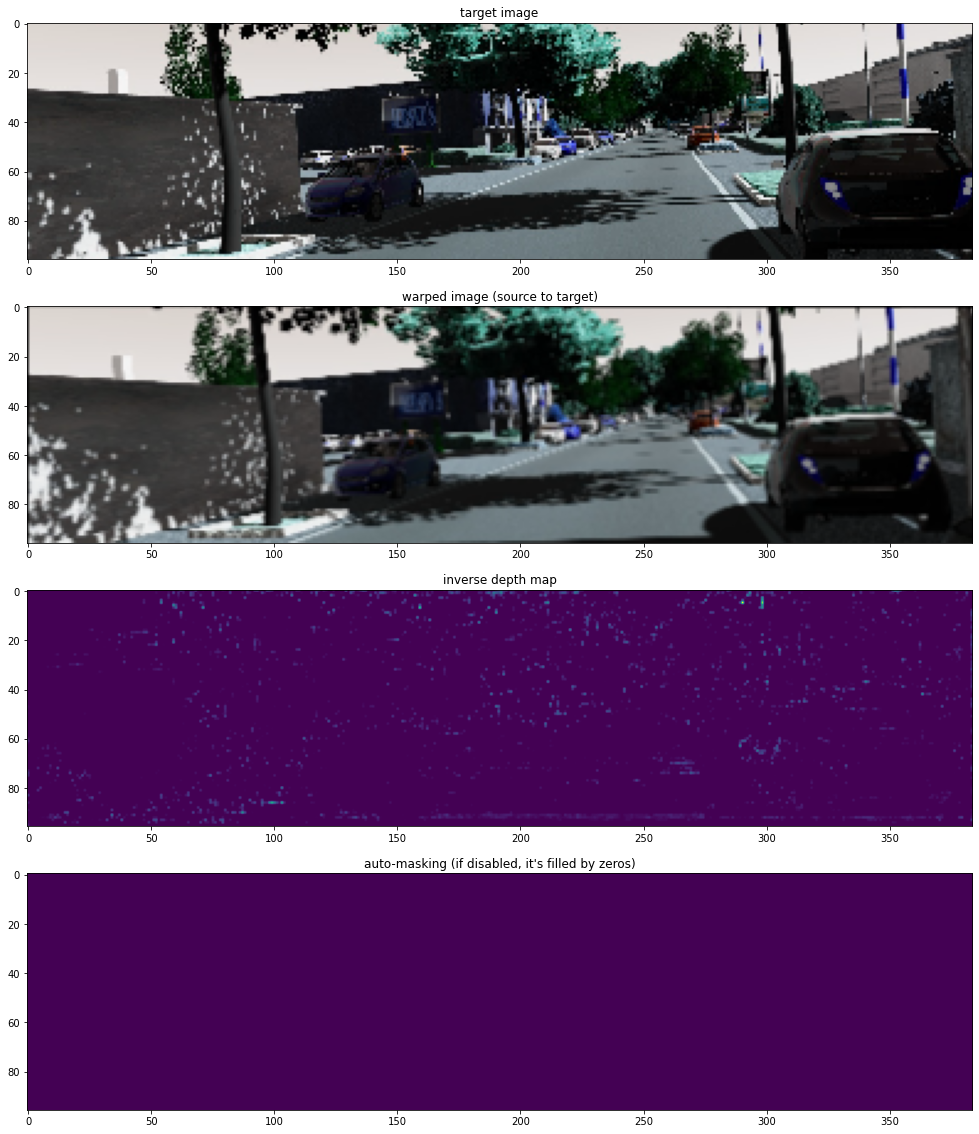

[Epoch 0] loss (ph): 0.197, loss (sm) 0.002, depth mean 100.028, lr 0.000400, trans mag 0.451: 100%|██████████| 132/132 [03:16<00:00,  1.49s/it]
  0%|          | 0/132 [00:00<?, ?it/s]

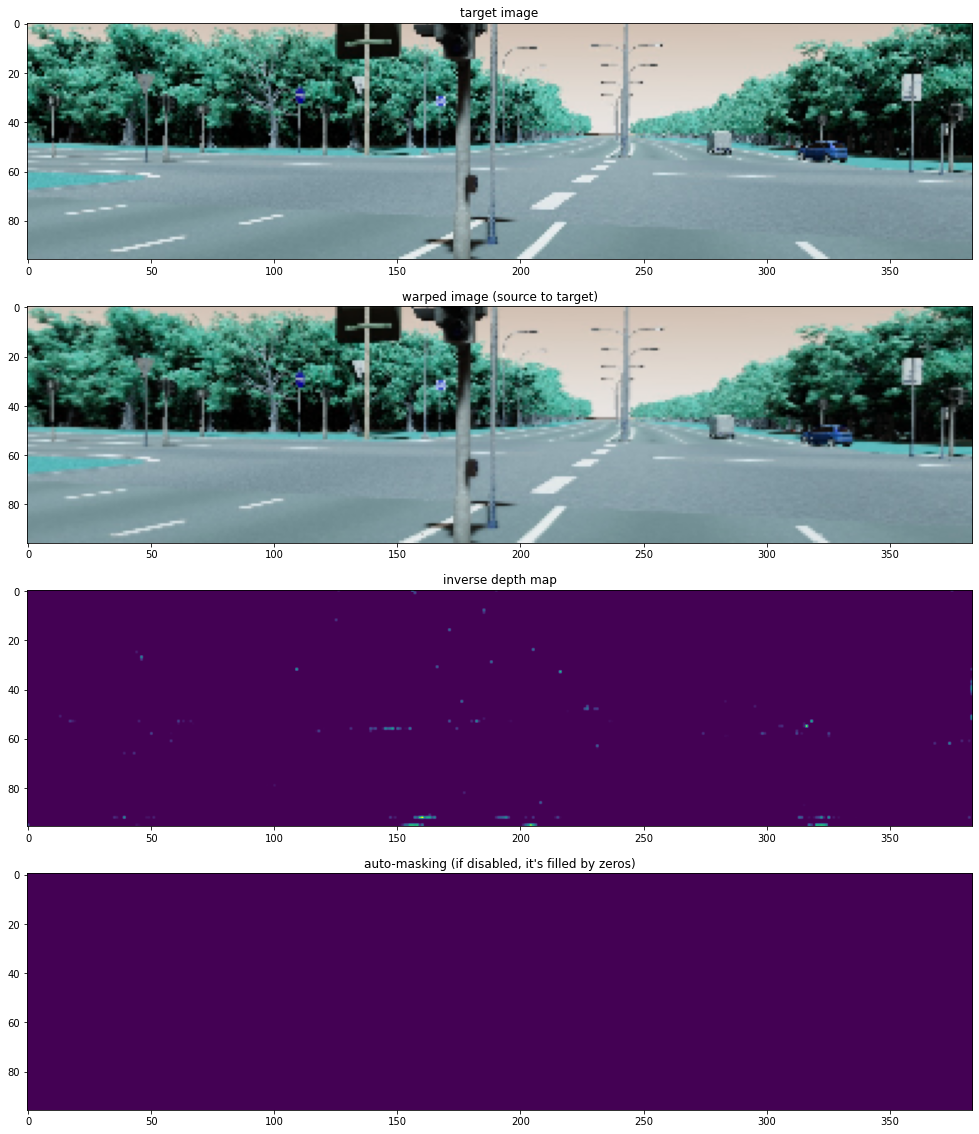

[Epoch 1] loss (ph): 0.191, loss (sm) 0.002, depth mean 100.271, lr 0.000400, trans mag 0.293:   3%|▎         | 4/132 [00:07<03:33,  1.67s/it]

In [10]:
import torch
from torch.optim import Adam
from torch.optim.lr_scheduler import MultiStepLR   
from tqdm import tqdm
import matplotlib.pyplot as plt
import math
import os


# GPUを使う場合（マルチGPUは非対応）
device="cuda:0"
# CPUを使う場合
# device="cpu"

# num_batch_accumulation = 4

depth_net.train().to(device)
pose_net.train().to(device)

# optimizerを定義。depth_netとpose_netの２つのネットワークのパラメタを渡す。
optimizer = Adam([
    {"params": depth_net.parameters()},
    {"params": pose_net.parameters()}],
    lr=lr,
    )

# learning rate schecdulerを定義。徐々にlrを減衰させる。
scheduler = MultiStepLR(optimizer, milestones=[30, 60, 90], gamma=0.5)

for i in range(epochs):
    with tqdm(train_dataloader) as pbar:
        for j, batch in enumerate(pbar):
            # GPUにバッチを転送する
            batch = {k:v.to(device) for k, v in batch.items()}

            # 深度を推定する
            inv_depth = depth_net(batch["rgb_0"])
            inv_depth = F.relu(inv_depth)
            inv_depth = inv_depth.squeeze(1)
            inv_depth = (inv_depth + 1e-2) / (1 + 1e-2) # inverse depthの最小値（最長深度）を1e-2（100）とする。
            depth = 1 / inv_depth

            # 姿勢を推定する
            image_concat = torch.cat([batch["rgb_0"], batch["rgb_-1"]], axis=1) # ソースとターゲットの２枚の画像を同時に入力する
            pose = torch.tanh(pose_net(image_concat))
            rotation, translation = pose[..., 0:3], pose[..., 3:]
            rotation = rotation * math.pi # 各軸の回転を最大でPiに限定する
            translation = translation * 5.0 # 各軸の並進を最大で5.0に限定する
            rtmat = tgm.rtvec_to_pose(torch.cat([rotation, translation], dim=-1))

            # Lossを計算する
            y = {k:v for k, v in batch.items() if k.startswith("rgb_") or k.startswith("intrinsic_")}
            y_pred = {
                "depth_0": depth,
                "inv_depth_0": inv_depth,
                "extrinsic_-1": rtmat,
            }
            loss_ph, image_warped, automask = photometric_loss(y, y_pred)
            loss_sm = smoothness_loss(y, y_pred)
            loss = (loss_ph * 0.95) + (loss_sm * 0.05)
            loss.backward()

            # if (j + 1) % num_batch_accumulation == 0:
            optimizer.step()
            optimizer.zero_grad()

            if j % 200 == 0:
                # デバッグのために１枚分の出力を表示する
                plt.figure(figsize=(20, 20))
                ax_image = plt.subplot(4, 1, 1)
                ax_warped = plt.subplot(4, 1, 2)
                ax_depth = plt.subplot(4, 1, 3)
                ax_automask = plt.subplot(4, 1, 4)

                ax_image.set_title("target image")
                ax_image.imshow(batch["rgb_0"][0].detach().cpu().numpy().transpose(1, 2, 0))
                
                ax_warped.set_title("warped image (source to target)")
                ax_warped.imshow(image_warped[-1][0].detach().cpu().numpy().transpose(1, 2, 0))

                ax_depth.set_title("inverse depth map")
                ax_depth.imshow(inv_depth[0].detach().cpu().numpy())

                ax_automask.set_title("auto-masking (if disabled, it's filled by zeros)")
                ax_automask.imshow(automask[0].detach().cpu().numpy())
                
                plt.savefig(f"debug/epoch_{i}_iter_{j}_output.jpeg")
                plt.show()

            # プログレスバーに現在の状態を出力する
            pbar.set_description(
                f"[Epoch {i}] loss (ph): {loss_ph:0.3f}, " \
                f"loss (sm) {loss_sm:0.3f}, " \
                f"depth mean {depth.mean():0.3f}, " \
                f"lr {scheduler.get_last_lr()[0]:0.6f}, " \
                f"trans mag {torch.linalg.vector_norm(pose[..., 3:], ord=2, dim=-1).mean():0.3f}")

    os.makedirs("../ckpt/", exist_ok=True)
    torch.save(
        {
            "model_state_dict": {
                "depth_net": depth_net.state_dict(),
                "pose_net": pose_net.state_dict(),
            }
        }, f"../ckpt/models_{i}_epoch.pt"    
    )
    scheduler.step()
